In [85]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d
from scipy.misc import imresize

import tensorflow as tf

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/lane/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = expanduser('~/data/images/Tkacik/cd01A')
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)
old_size = patches[0].shape[0]
height = 32
width = 32
resized_pixels_to_degree = float(height/old_size) * pixelsToDeg
images = [imresize(p, (height, width), interp='bilinear') for p in patches]

Only 70 files in directory.


In [23]:
old_size/pixelsToDeg

21.869565217391305

In [24]:
32/resized_pixels_to_degree

21.869565217391308

In [20]:
resized_pixels_to_degree

1.4632206759443338

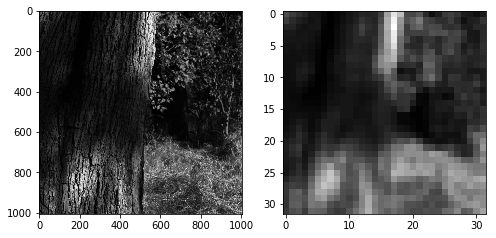

In [43]:
image_id = 16
fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(patches[image_id], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(images[image_id], cmap='gray')

In [248]:
def difference_of_gaussians_2d(center_sigma, surround_sigma, xmin=-2.5, xmax=2.5, spacing=7):
    mesh = np.meshgrid(np.linspace(xmin,xmax,spacing), np.linspace(xmin,xmax,spacing))
    center_gauss = gaussian(x=mesh[0], mu=0.0, sigma=center_sigma) * gaussian(
        x=mesh[1], mu=0.0, sigma=center_sigma)
    surround_gauss = gaussian(x=mesh[0], mu=0.0, sigma=surround_sigma) * gaussian(
        x=mesh[1], mu=0.0, sigma=surround_sigma)
    return center_gauss/np.sum(center_gauss) - surround_gauss/np.sum(surround_gauss)
    #return center_gauss - surround_gauss

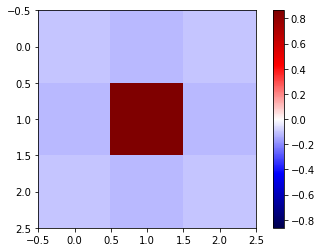

In [247]:
filt = difference_of_gaussians_2d(0.5, 4.5, spacing=3)
plt.imshow(filt, cmap='seismic', clim=[-np.max(abs(filt)), np.max(abs(filt))])
plt.colorbar()

In [55]:
homogenous_filters = [difference_of_gaussians_2d(0.5, 1.5),
                      difference_of_gaussians_2d(0.5, 1.5),
                      difference_of_gaussians_2d(0.5, 1.5)]
diverse_filters = [difference_of_gaussians_2d(0.5, 1.5),
                   difference_of_gaussians_2d(0.2, 1.0),
                   difference_of_gaussians_2d(0.5, 4.0)]
homogenous_image_data = [np.stack([convolve2d(patch,
                                              filt,
                                              mode='valid') for filt in homogenous_filters]) for patch in images]
diverse_image_data = [np.stack([convolve2d(patch,
                                           filt,
                                           mode='valid') for filt in diverse_filters]) for patch in images]

In [56]:
homogenous_image_data[0].shape

(3, 26, 26)

In [57]:
diverse_image_data[0].shape

(3, 26, 26)

In [58]:
len(diverse_image_data)

70

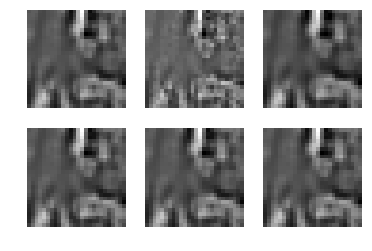

In [63]:
image_id = 16
fig = plt.figure(figsize=(6,4))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(diverse_image_data[image_id][i], cmap='gray')
    plt.axis('off')
    
for j in range(3,6):
    plt.subplot(2,3,j+1)
    plt.imshow(homogenous_image_data[image_id][j-3], cmap='gray')
    plt.axis('off')

### Stride the input data

In [67]:
homogenous_data = [np.stack([d[i][i:-3+i:3, i:-3+i:3] for i in range(3)], axis=-1) for d in homogenous_image_data]
diverse_data = [np.stack([d[i][i:-3+i:3, i:-3+i:3] for i in range(3)], axis=-1) for d in diverse_image_data]
groundtruth_data = [imresize(p, (8, 8), interp='bilinear') for p in patches]

In [68]:
groundtruth_data[0].shape

(8, 8)

In [69]:
homogenous_data[0].shape

(8, 8, 3)

In [70]:
diverse_data[0].shape

(8, 8, 3)

In [71]:
homogenous_image_data[0].shape

(3, 26, 26)

# The distortion (compression) is linear, but the best reconstruction can still be nonlinear, if it learns about the structure of natural images. The best reconstruction for whitenoise would be linear.

In [72]:
d = diverse_image_data[0]
blah = np.stack([d[i][i:-3+i:3, i:-3+i:3] for i in range(3)], axis=-1)

In [73]:
blah.shape

(8, 8, 3)

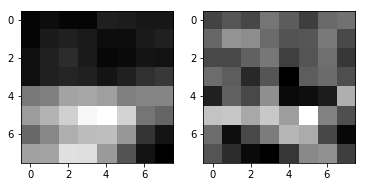

In [76]:
fig = plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(groundtruth_data[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(blah[:, :, 2], cmap='gray')

## Learn a small linear neural network to decode these images.

In [101]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

In [114]:
max_epochs = 100
batch_size = 1

In [129]:
g = tf.Graph()
with g.as_default():
    distortion = tf.placeholder(tf.float32, shape=(batch_size, 302, 302, 3))
    label = tf.placeholder(tf.float32, shape=(302, 302))
    # inputs, num_outputs, kernel_size, stride=1
    layer1 = tf.layers.conv2d_transpose(distortion, 1, 21, padding='valid')
    layer1 = tf.image.resize_bilinear(layer1, [302, 302])
    mse = tf.losses.mean_squared_error(label, tf.squeeze(layer1))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)
    
    step = 0
    with tf.Session() as sess:
        for i in range(max_epochs):
            for inp, patch in zip(homogenous_data, groundtruth_data):
                sess.run(tf.global_variables_initializer())
                update, error = sess.run([train_op, mse], feed_dict={distortion: np.expand_dims(inp, 0),
                                                                     label: patch})
                #print('Error at step %04d is %0.4f' %(step, error))
                step += 1
            print('Error at epoch %03d is %0.4f' %(i, error))

Error at epoch 000 is 2855.2524
Error at epoch 001 is 2855.8201
Error at epoch 002 is 2857.9878
Error at epoch 003 is 2857.8093
Error at epoch 004 is 2856.6082
Error at epoch 005 is 2858.3528
Error at epoch 006 is 2858.2483
Error at epoch 007 is 2858.9028
Error at epoch 008 is 2858.6538
Error at epoch 009 is 2858.9712
Error at epoch 010 is 2856.8230
Error at epoch 011 is 2857.5454
Error at epoch 012 is 2855.3235
Error at epoch 013 is 2859.3101
Error at epoch 014 is 2858.9668
Error at epoch 015 is 2858.4402
Error at epoch 016 is 2858.8440
Error at epoch 017 is 2858.1467
Error at epoch 018 is 2859.8760
Error at epoch 019 is 2858.6990
Error at epoch 020 is 2861.0986
Error at epoch 021 is 2858.3926
Error at epoch 022 is 2861.7786
Error at epoch 023 is 2855.7866
Error at epoch 024 is 2860.6787
Error at epoch 025 is 2859.7939
Error at epoch 026 is 2856.9541
Error at epoch 027 is 2859.5378
Error at epoch 028 is 2859.8882
Error at epoch 029 is 2861.7183
Error at epoch 030 is 2857.4426
Error at

# Fully connected linear layer

In [79]:
homogenous_data = [np.stack([d[i][i:-3+i:3, i:-3+i:3] for i in range(3)], axis=-1) for d in homogenous_image_data]
diverse_data = [np.stack([d[i][i:-3+i:3, i:-3+i:3] for i in range(3)], axis=-1) for d in diverse_image_data]
groundtruth_data = [imresize(p, (8, 8), interp='bilinear') for p in images]

In [80]:
homogenous_data[0].shape

(8, 8, 3)

In [81]:
groundtruth_data[0].shape

(8, 8)

(-0.5, 7.5, 7.5, -0.5)

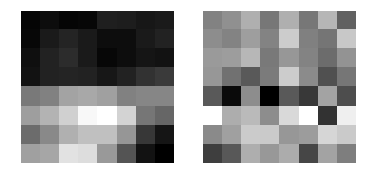

In [83]:
fig = plt.figure(figsize=(6,4))
plt.subplot(1,2,1)
plt.imshow(groundtruth_data[0], cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(homogenous_data[0][:,:,0], cmap='gray')
plt.axis('off')

In [89]:
batch_size = 1
max_epochs = 100

In [90]:
height = 8
width = 8
g = tf.Graph()
with g.as_default():
    distortion = tf.placeholder(tf.float32, shape=(batch_size, height, width, 3))
    label = tf.placeholder(tf.float32, shape=(height, width))
    # inputs, num_outputs, kernel_size, stride=1
    flattened_input = tf.contrib.layers.flatten(distortion)
    layer1 = tf.layers.dense(flattened_input, height*width)
    layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    layer1 = tf.image.resize_bilinear(layer1, [height, width])
    mse = tf.losses.mean_squared_error(label, tf.squeeze(layer1))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)
    
    step = 0
    with tf.Session() as sess:
        for i in range(max_epochs):
            for inp, patch in zip(homogenous_data, groundtruth_data):
                sess.run(tf.global_variables_initializer())
                update, error = sess.run([train_op, mse], feed_dict={distortion: np.expand_dims(inp, 0),
                                                                     label: patch})
                #print('Error at step %04d is %0.4f' %(step, error))
                step += 1
            print('Error at epoch %03d is %0.4f' %(i, error))

Error at epoch 000 is 2311.5728
Error at epoch 001 is 2093.9307
Error at epoch 002 is 2107.5210
Error at epoch 003 is 2248.8955
Error at epoch 004 is 2266.7036
Error at epoch 005 is 2080.7134
Error at epoch 006 is 2107.7446
Error at epoch 007 is 2087.4390
Error at epoch 008 is 2061.6951
Error at epoch 009 is 2111.4077
Error at epoch 010 is 2062.2903
Error at epoch 011 is 2155.3213
Error at epoch 012 is 2393.6282
Error at epoch 013 is 2254.3726
Error at epoch 014 is 2184.6465
Error at epoch 015 is 2021.2061
Error at epoch 016 is 2043.3853
Error at epoch 017 is 2097.5222
Error at epoch 018 is 1981.9683
Error at epoch 019 is 2115.1689
Error at epoch 020 is 1943.6648
Error at epoch 021 is 2238.5044
Error at epoch 022 is 2131.3906
Error at epoch 023 is 1984.8302
Error at epoch 024 is 2115.2930
Error at epoch 025 is 2250.0574
Error at epoch 026 is 1962.8650
Error at epoch 027 is 1965.9117
Error at epoch 028 is 1991.4590
Error at epoch 029 is 2182.7029
Error at epoch 030 is 2146.2161
Error at

# Do this more seriously, with a data generator and larger batch sizes.

In [249]:
def data_generator(batch_size, crop_size=32):
    random_image = [patches[c] for c in np.random.choice(len(patches), batch_size)]
    random_y = np.random.choice(patches[0].shape[0] - crop_size, batch_size)
    random_x = np.random.choice(patches[0].shape[1] - crop_size, batch_size)
    random_patches = [p[y:y+crop_size, x:x+crop_size] for x,y,p in zip(random_x, random_y, random_image)]
    return np.stack(random_patches)


homogenous_filters = [difference_of_gaussians_2d(0.5, 4.5, spacing=3),
                      difference_of_gaussians_2d(0.5, 4.5, spacing=3),
                      difference_of_gaussians_2d(0.5, 4.5, spacing=3)]
diverse_filters = [difference_of_gaussians_2d(0.5, 4.5, spacing=3),
                   difference_of_gaussians_2d(0.2, 1.0, spacing=3),
                   difference_of_gaussians_2d(0.5, 4.0, spacing=3)]
def distort_data(batch_size, crop_size=32, diverse=False):
    images = data_generator(batch_size, crop_size=crop_size)
    if diverse:
        data = [np.stack([convolve2d(p,
                                     filt,
                                     mode='valid') for filt in diverse_filters]) for p in images]
    else:
        data = [np.stack([convolve2d(p,
                                     filt,
                                     mode='valid') for filt in homogenous_filters]) for p in images]
    return (np.stack([np.stack([d[i][i:-3+i, i:-3+i] for i in range(3)], axis=-1) for d in data]), images)

In [217]:
(xs, labels) = distort_data(32)

In [218]:
xs.shape

(32, 27, 27, 3)

In [219]:
labels.shape

(32, 32, 32)

In [220]:
xs[0].shape

(27, 27, 3)

In [221]:
labels[0].shape

(32, 32)

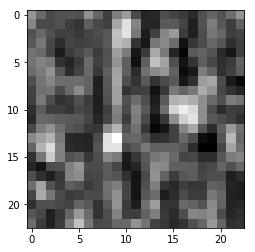

In [222]:
plt.imshow(blah[0][:,:,2], cmap='gray')

In [233]:
in_size = 27
out_size = 32
batch_size = 32
max_steps = 30000
g = tf.Graph()
results = collections.defaultdict(list)
with g.as_default():
    distortion = tf.placeholder(tf.float32, shape=(batch_size, in_size, in_size, 3))
    label = tf.placeholder(tf.float32, shape=(batch_size, out_size, out_size))
    # inputs, num_outputs, kernel_size, stride=1
    flattened_input = tf.contrib.layers.flatten(distortion)
    print(flattened_input.get_shape())
    layer1 = tf.layers.dense(flattened_input, out_size**2)
    layer1 = tf.reshape(layer1, shape=[batch_size, out_size, out_size, 1])
    print(layer1.get_shape())
    print(label.get_shape())
    mse = tf.losses.mean_squared_error(label, tf.squeeze(layer1))
    opt = tf.train.GradientDescentOptimizer(0.01)
    train_op = opt.minimize(mse)
    
    step = 0
    errors = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(max_steps):
            input_data, labels = distort_data(batch_size, crop_size=out_size, diverse=False)
            update, error = sess.run([train_op, mse], feed_dict={distortion: input_data,
                                                                 label: labels})
            errors.append(error)
            #print('Error at step %04d is %0.4f' %(step, error))
            if i % 500 == 0:
                print('Error at step %03d is %0.4f' %(i, error))
                results['input'].append(input_data)
                results['labels'].append(labels)
                output = sess.run([layer1], feed_dict={distortion: input_data, label: labels})
                results['output'].append(output)

(32, 2187)
(32, 32, 32, 1)
(32, 32, 32)
Error at step 000 is 10.0528
Error at step 500 is 0.6223
Error at step 1000 is 0.3557
Error at step 1500 is 0.4406
Error at step 2000 is 0.2985
Error at step 2500 is 0.2690
Error at step 3000 is 0.5042
Error at step 3500 is 0.4705
Error at step 4000 is 0.3413
Error at step 4500 is 0.3809
Error at step 5000 is 0.3593
Error at step 5500 is 0.3362
Error at step 6000 is 0.4034
Error at step 6500 is 0.2274
Error at step 7000 is 0.3422
Error at step 7500 is 0.3080
Error at step 8000 is 0.3061
Error at step 8500 is 0.3354
Error at step 9000 is 0.2513
Error at step 9500 is 0.3834
Error at step 10000 is 0.2823
Error at step 10500 is 0.2348
Error at step 11000 is 0.2661
Error at step 11500 is 0.4172
Error at step 12000 is 0.3213
Error at step 12500 is 0.3212
Error at step 13000 is 0.3448
Error at step 13500 is 0.3633
Error at step 14000 is 0.3663
Error at step 14500 is 0.2596
Error at step 15000 is 0.2522
Error at step 15500 is 0.4035
Error at step 16000 i

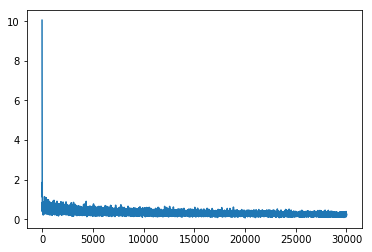

In [234]:
plt.plot(errors)

In [235]:
results['input'][0].shape

(32, 27, 27, 3)

In [236]:
results['labels'][0].shape

(32, 32, 32)

In [237]:
results['output'][0][0].shape

(32, 32, 32, 1)

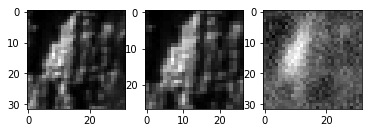

In [239]:
stage = -1
batch_id = 2
plt.subplot(1,3,1)
plt.imshow(results['labels'][stage][batch_id], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(results['input'][stage][batch_id, :, :, 0], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(results['output'][stage][0][batch_id, :, :, 0], cmap='gray')

In [190]:
np.mean(results['labels'][stage][batch_id])

2.298895264403332

In [191]:
np.mean(results['output'][stage][0][batch_id, :, :, 0])

0.00026322043

In [192]:
np.mean(results['input'][stage][batch_id, :, :, 0])

-0.0035328977091702066

In [223]:
x, l = distort_data(32)

In [224]:
x[0].shape

(27, 27, 3)

In [226]:
in_size = 27
out_size = 32
batch_size = 32
max_steps = 30000
g = tf.Graph()
results = collections.defaultdict(list)
with g.as_default():
    distortion = tf.placeholder(tf.float32, shape=(batch_size, in_size, in_size, 3))
    label = tf.placeholder(tf.float32, shape=(batch_size, out_size, out_size))
    # inputs, num_outputs, kernel_size, stride=1
    flattened_input = tf.contrib.layers.flatten(distortion)
    print(flattened_input.get_shape())
    layer1 = tf.layers.dense(flattened_input, 512, activation=tf.nn.relu)
    layer2 = tf.layers.dense(layer1, 256, activation=tf.nn.relu)
    layer3 = tf.layers.dense(layer2, out_size*out_size)
    layer3 = tf.reshape(layer3, shape=[batch_size, out_size, out_size, 1])
    print(layer1.get_shape())
    print(label.get_shape())
    mse = tf.losses.mean_squared_error(label, tf.squeeze(layer3))
    opt = tf.train.GradientDescentOptimizer(0.01)
    train_op = opt.minimize(mse)
    
    step = 0
    errors = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(max_steps):
            input_data, labels = distort_data(batch_size, crop_size=out_size, diverse=False)
            update, error = sess.run([train_op, mse], feed_dict={distortion: input_data,
                                                                 label: labels})
            errors.append(error)
            #print('Error at step %04d is %0.4f' %(step, error))
            if i % 500 == 0:
                print('Error at step %03d is %0.4f' %(i, error))
                results['input'].append(input_data)
                results['labels'].append(labels)
                output = sess.run([layer3], feed_dict={distortion: input_data, label: labels})[0]
                results['output'].append(output)

(32, 2187)
(32, 512)
(32, 32, 32)
Error at step 000 is 8.9513
Error at step 500 is 0.4838
Error at step 1000 is 0.5388
Error at step 1500 is 0.4182
Error at step 2000 is 0.4121
Error at step 2500 is 0.3456
Error at step 3000 is 0.3294
Error at step 3500 is 0.5102
Error at step 4000 is 0.3237
Error at step 4500 is 0.2987
Error at step 5000 is 0.4654
Error at step 5500 is 0.4468
Error at step 6000 is 0.3564
Error at step 6500 is 0.4002
Error at step 7000 is 0.3856
Error at step 7500 is 0.3639
Error at step 8000 is 0.2825
Error at step 8500 is 0.4224
Error at step 9000 is 0.2779
Error at step 9500 is 0.4186
Error at step 10000 is 0.4919
Error at step 10500 is 0.3384
Error at step 11000 is 0.4382
Error at step 11500 is 0.5322
Error at step 12000 is 0.2810
Error at step 12500 is 0.3030
Error at step 13000 is 0.2579
Error at step 13500 is 0.3446
Error at step 14000 is 0.4616
Error at step 14500 is 0.2750
Error at step 15000 is 0.4707
Error at step 15500 is 0.3633
Error at step 16000 is 0.321

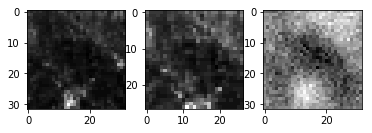

In [228]:
stage = -1
batch_id = 2
plt.subplot(1,3,1)
plt.imshow(results['labels'][stage][batch_id], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(results['input'][stage][batch_id, :, :, 0], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(results['output'][stage][batch_id, :, :, 0], cmap='gray')

In [198]:
len(results['output'])

28

In [200]:
results['output'][16][0].shape

(32, 512)

In [229]:
np.mean(results['input'][stage][batch_id, :, :, 0])

0.82166260973710126

In [230]:
np.mean(results['labels'][stage][batch_id])

2.0500925789141693

In [231]:
np.mean(results['output'][stage][batch_id, :, :, 0])

2.0549705

# Convolutional version

In [244]:
in_size = 27
out_size = 32
batch_size = 32
max_steps = 30000
g = tf.Graph()
results = collections.defaultdict(list)
with g.as_default():
    distortion = tf.placeholder(tf.float32, shape=(batch_size, in_size, in_size, 3))
    label = tf.placeholder(tf.float32, shape=(batch_size, out_size, out_size))
    # inputs, num_outputs, kernel_size, stride=1
    layer1 = tf.layers.conv2d_transpose(distortion, 1, 6, padding='valid')
    print(layer1.get_shape())
    print(label.get_shape())
    mse = tf.losses.mean_squared_error(label, tf.squeeze(layer1))
    opt = tf.train.GradientDescentOptimizer(0.01)
    train_op = opt.minimize(mse)
    
    step = 0
    errors = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(max_steps):
            input_data, labels = distort_data(batch_size, crop_size=out_size, diverse=False)
            update, error = sess.run([train_op, mse], feed_dict={distortion: input_data,
                                                                 label: labels})
            errors.append(error)
            #print('Error at step %04d is %0.4f' %(step, error))
            if i % 500 == 0:
                print('Error at step %03d is %0.4f' %(i, error))
                results['input'].append(input_data)
                results['labels'].append(labels)
                output = sess.run([layer1], feed_dict={distortion: input_data, label: labels})[0]
                results['output'].append(output)

(32, 32, 32, 1)
(32, 32, 32)
Error at step 000 is 15.8574
Error at step 500 is 0.6066
Error at step 1000 is 1.0120
Error at step 1500 is 0.7823
Error at step 2000 is 1.3298
Error at step 2500 is 0.7360
Error at step 3000 is 0.5898
Error at step 3500 is 8.5562
Error at step 4000 is 0.6511
Error at step 4500 is 1.0313
Error at step 5000 is 1.4223
Error at step 5500 is 0.7360
Error at step 6000 is 1.7088
Error at step 6500 is 0.6886
Error at step 7000 is 9.9974
Error at step 7500 is 0.7726
Error at step 8000 is 0.6040
Error at step 8500 is 0.4628
Error at step 9000 is 0.6681
Error at step 9500 is 1.2512
Error at step 10000 is 0.6434
Error at step 10500 is 0.8329
Error at step 11000 is 0.8961
Error at step 11500 is 0.4985
Error at step 12000 is 1.1536
Error at step 12500 is 11.4867
Error at step 13000 is 0.7073
Error at step 13500 is 1.5599
Error at step 14000 is 0.9642
Error at step 14500 is 0.7732
Error at step 15000 is 0.6234
Error at step 15500 is 0.6231
Error at step 16000 is 0.6790
E

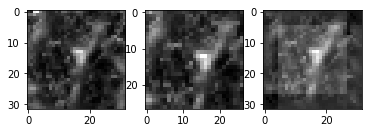

In [245]:
stage = -1
batch_id = 2
plt.subplot(1,3,1)
plt.imshow(results['labels'][stage][batch_id], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(results['input'][stage][batch_id, :, :, 0], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(results['output'][stage][batch_id, :, :, 0], cmap='gray')

# With center-surround

In [250]:
in_size = 27
out_size = 32
batch_size = 32
max_steps = 30000
g = tf.Graph()
results = collections.defaultdict(list)
with g.as_default():
    distortion = tf.placeholder(tf.float32, shape=(batch_size, in_size, in_size, 3))
    label = tf.placeholder(tf.float32, shape=(batch_size, out_size, out_size))
    # inputs, num_outputs, kernel_size, stride=1
    layer1 = tf.layers.conv2d_transpose(distortion, 1, 6, padding='valid')
    print(layer1.get_shape())
    print(label.get_shape())
    mse = tf.losses.mean_squared_error(label, tf.squeeze(layer1))
    opt = tf.train.GradientDescentOptimizer(0.01)
    train_op = opt.minimize(mse)
    
    step = 0
    errors = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(max_steps):
            input_data, labels = distort_data(batch_size, crop_size=out_size, diverse=False)
            update, error = sess.run([train_op, mse], feed_dict={distortion: input_data,
                                                                 label: labels})
            errors.append(error)
            #print('Error at step %04d is %0.4f' %(step, error))
            if i % 500 == 0:
                print('Error at step %03d is %0.4f' %(i, error))
                results['input'].append(input_data)
                results['labels'].append(labels)
                output = sess.run([layer1], feed_dict={distortion: input_data, label: labels})[0]
                results['output'].append(output)

(32, 32, 32, 1)
(32, 32, 32)
Error at step 000 is 8.6020
Error at step 500 is 0.9475
Error at step 1000 is 0.6832
Error at step 1500 is 0.8759
Error at step 2000 is 0.9805
Error at step 2500 is 0.7174
Error at step 3000 is 0.8023
Error at step 3500 is 0.6073
Error at step 4000 is 0.5134
Error at step 4500 is 0.7470
Error at step 5000 is 0.7838
Error at step 5500 is 0.8729
Error at step 6000 is 1.8877
Error at step 6500 is 0.7620
Error at step 7000 is 0.5879
Error at step 7500 is 0.5749
Error at step 8000 is 0.8504
Error at step 8500 is 0.5432
Error at step 9000 is 0.7134
Error at step 9500 is 0.5060
Error at step 10000 is 0.8314
Error at step 10500 is 1.0083
Error at step 11000 is 0.8058
Error at step 11500 is 0.5479
Error at step 12000 is 0.6841
Error at step 12500 is 0.4997
Error at step 13000 is 0.7479
Error at step 13500 is 0.6471
Error at step 14000 is 1.3250
Error at step 14500 is 0.7623
Error at step 15000 is 0.4953
Error at step 15500 is 1.1382
Error at step 16000 is 0.5730
Err

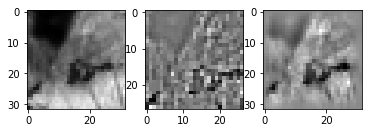

In [251]:
stage = -1
batch_id = 2
plt.subplot(1,3,1)
plt.imshow(results['labels'][stage][batch_id], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(results['input'][stage][batch_id, :, :, 0], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(results['output'][stage][batch_id, :, :, 0], cmap='gray')

In [252]:
homogenous_errors = errors
homogenous_results = results

# Diverse version

In [253]:
in_size = 27
out_size = 32
batch_size = 32
max_steps = 30000
g = tf.Graph()
results = collections.defaultdict(list)
with g.as_default():
    distortion = tf.placeholder(tf.float32, shape=(batch_size, in_size, in_size, 3))
    label = tf.placeholder(tf.float32, shape=(batch_size, out_size, out_size))
    # inputs, num_outputs, kernel_size, stride=1
    layer1 = tf.layers.conv2d_transpose(distortion, 1, 6, padding='valid')
    print(layer1.get_shape())
    print(label.get_shape())
    mse = tf.losses.mean_squared_error(label, tf.squeeze(layer1))
    opt = tf.train.GradientDescentOptimizer(0.01)
    train_op = opt.minimize(mse)
    
    step = 0
    errors = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(max_steps):
            input_data, labels = distort_data(batch_size, crop_size=out_size, diverse=True)
            update, error = sess.run([train_op, mse], feed_dict={distortion: input_data,
                                                                 label: labels})
            errors.append(error)
            #print('Error at step %04d is %0.4f' %(step, error))
            if i % 500 == 0:
                print('Error at step %03d is %0.4f' %(i, error))
                results['input'].append(input_data)
                results['labels'].append(labels)
                output = sess.run([layer1], feed_dict={distortion: input_data, label: labels})[0]
                results['output'].append(output)

(32, 32, 32, 1)
(32, 32, 32)
Error at step 000 is 9.0330
Error at step 500 is 0.9071
Error at step 1000 is 0.8807
Error at step 1500 is 1.1074
Error at step 2000 is 0.5821
Error at step 2500 is 1.2145
Error at step 3000 is 0.7120
Error at step 3500 is 0.7144
Error at step 4000 is 0.7858
Error at step 4500 is 1.1432
Error at step 5000 is 0.5329
Error at step 5500 is 0.9122
Error at step 6000 is 0.9840
Error at step 6500 is 0.5608
Error at step 7000 is 0.6869
Error at step 7500 is 0.5961
Error at step 8000 is 0.5043
Error at step 8500 is 0.7500
Error at step 9000 is 0.7996
Error at step 9500 is 0.6858
Error at step 10000 is 0.7146
Error at step 10500 is 0.7166
Error at step 11000 is 0.6526
Error at step 11500 is 0.5724
Error at step 12000 is 0.5800
Error at step 12500 is 0.7430
Error at step 13000 is 0.5479
Error at step 13500 is 0.5964
Error at step 14000 is 0.3728
Error at step 14500 is 0.6142
Error at step 15000 is 0.9535
Error at step 15500 is 0.5467
Error at step 16000 is 1.0937
Err

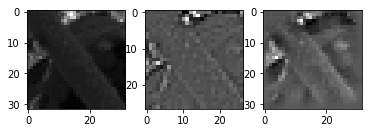

In [254]:
stage = -1
batch_id = 2
plt.subplot(1,3,1)
plt.imshow(results['labels'][stage][batch_id], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(results['input'][stage][batch_id, :, :, 0], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(results['output'][stage][batch_id, :, :, 0], cmap='gray')

In [255]:
diverse_errors = errors
diverse_results = results

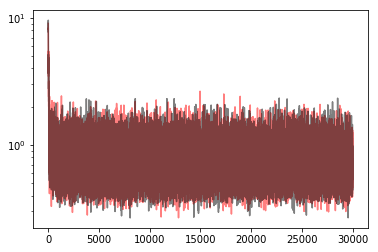

In [261]:
plt.plot(diverse_errors, 'r', alpha=0.5)
plt.plot(homogenous_errors, 'k', alpha=0.5)
plt.yscale('log')

# Get appropriately sized/shaped filters from retinal data.

In [377]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = int(retina_width/photoreceptor_width) - 1
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

In [379]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells(space_mode='peak')
cells['bipolar'] = load_bipolar_cells(space_mode='peak')
cells['amacrine'] = load_amacrine_cells(space_mode='peak')
cells['horizontal'] = load_horizontal_cells(space_mode='peak')

In [380]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))
        
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)

In [381]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg, kind='peak')
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

In [ ]:
corr_map = {}
for celltype in receptive_fields.keys():
    corr_map[celltype] = np.zeros((len(receptive_fields[celltype]), len(receptive_fields[celltype])))
    for idr1, rf1 in tqdm(enumerate(receptive_fields[celltype])):
        for idr2 in range(idr1+1, len(receptive_fields[celltype])):
            rf2 = receptive_fields[celltype][idr2]
            corr_map[celltype][idr1, idr2] = pearsonr(rf1, rf2)[0]

unduplicated_receptive_fields = collections.defaultdict(list)
duplicates = collections.defaultdict(list)

for celltype in corr_map.keys():
    these_dups = []
    for row in corr_map[celltype]:
        these_dups.append([i for i in range(len(row)) if row[i] == 1.0])
    duplicates[celltype] = np.unique(np.hstack(these_dups))
    
unduplicated_receptive_fields = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    for idr, rf in enumerate(receptive_fields[celltype]):
        if idr not in duplicates[celltype]:
            unduplicated_receptive_fields[celltype].append(rf)
            
receptive_fields = unduplicated_receptive_fields.copy()
del unduplicated_receptive_fields

28it [00:00, 913.07it/s]
2it [00:00, 11140.25it/s]
2it [00:00, 10578.32it/s]
2it [00:00, 10498.88it/s]
126it [00:00, 185.32it/s]
772it [00:24, 32.01it/s] 
249it [00:02, 99.83it/s] 
321it [00:04, 77.83it/s] 
253it [00:02, 98.20it/s] 


In [ ]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype].append(idg)
            
                # just set params to median across cells
                # this way the params are still aligned with the receptive field id
                center_widths[celltype].append(np.median(center_widths[celltype]))
                surround_widths[celltype].append(np.median(surround_widths[celltype]))
                center_strengths[celltype].append(np.median(center_strengths[celltype]))
                surround_strengths[celltype].append(np.median(surround_strengths[celltype]))
                
#                 print("Couldn't fit cell %d" %idg)

28it [00:16,  1.40s/it]
58it [00:22,  3.16it/s]
479it [01:37,  5.83it/s]

In [ ]:
median_center_widths = {}
for celltype in center_widths.keys():
    cws = np.array(center_widths[celltype])
    sws = np.array(surround_widths[celltype])
    css = np.array(center_strengths[celltype])
    sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(abs(cws))
    median_surround_width = np.median(abs(sws))
    median_center_strength = np.median(-abs(css))
    median_surround_strength = np.median(abs(sss))
#     plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
#                                      median_center_strength, median_surround_strength), label=celltype)
# plt.legend(frameon=False, fontsize=9, loc='lower left')
# adjust_spines(plt.gca())

In [ ]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)
def center_and_surround(space, center_width, surround_width, center_strength, surround_strength):
    return diff_of_gauss_mu0(space, abs(center_width), abs(surround_width),
                            -abs(center_strength), abs(surround_strength))

In [ ]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

In [ ]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

In [ ]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

In [ ]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing = 1./pixelsToDeg # number of degree spacing between pixels
normalize = 'divisive'
contrast = 0.35
signal = np.array(np.load('signal_3_23.npy'))

In [ ]:
input_noise = 0.098762200628786892
output_noise = 0.35
target_power = 54.131410989171826

In [ ]:
plt.plot(signal, '.')

In [ ]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

# SNR = 0.269 is total SNR from ganglion recordings of 112 repeats to 30 seconds natural scenes
def find_filt_const(filt_const):
    this_snr = get_snr(input_noise, output_noise, signal, filt_const*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

filt_const_opt = scipy.optimize.minimize_scalar(find_filt_const)

our_snr = get_snr(input_noise, output_noise, signal, filt_const_opt.x*average_ganglion_fft, mode='variance')

plt.scatter(filt_const_opt.x, our_snr, s=20, color='k')

In [ ]:
resolution = 150
horz_weights = np.linspace(0,1,resolution)
center_weights = np.linspace(0,1,resolution)

In [ ]:
median_center_widths

In [ ]:
len(signal)

In [ ]:
init_filt_const = 10.9
info_maps = collections.defaultdict(list) # one info map per celltype (since they will be a function of center width)
failures = collections.defaultdict(list)
detailed_failures = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
        center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf
        
        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
        
#         print('Information map for %s cells.' %celltype)
        
        infomap = np.zeros((resolution, resolution))
        for idh,hw in tqdm(enumerate(horz_weights)):
            for idc,cw in enumerate(center_weights):
                rf = rf_model(hw, cw)
                rf_filt = abs(np.fft.rfft(rf))
                
                # constrain model
                def constrain_filt_power(filt_const):
                    size = len(rf_filt)
                    output_power = np.sum((signal*filt_const*rf_filt)**2 
                                          + (input_noise*filt_const*rf_filt)**2
                                          + output_noise**2)
                    
                    return (target_power - output_power)**2

                filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
                iterations = 0
                new_init_filt_const = init_filt_const
                while not filt_const_opt.success:
                    iterations += 1
                    new_init_filt_const *= 10
                    filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
                    if iterations > 10:
                        detailed_failures[celltype] = filt_const_opt
                        break
                
                filt_const = abs(filt_const_opt['x'])
                
                if not filt_const_opt.success:
                    failures[celltype].append([hw, cw])

                signal_power = (filt_const * rf_filt * signal)**2
                noise_power = (filt_const * rf_filt * input_noise)**2 + output_noise**2
                infomap[idh,idc] = 0.5*np.sum(np.log2(1 + signal_power/noise_power))
        info_maps[celltype] = infomap

In [414]:
celltype = 'medium_off_adapting'
center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

def rf_model(horz_weight, center_weight):
    return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)

In [415]:
np.unravel_index(np.argmax(info_maps[celltype]), (resolution, resolution))

(7, 79)

In [417]:
info_maps[celltype][7, 79]

9.4127817834488958

In [418]:
horz_weights[7]

0.046979865771812082

In [419]:
center_weights[79]

0.53020134228187921

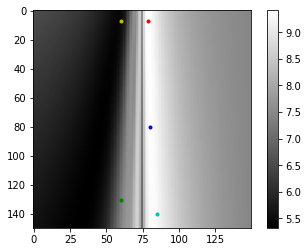

In [434]:
plt.imshow(info_maps[celltype], cmap='gray')
plt.plot([79], [7], 'r.')
plt.plot([60], [7], 'y.')
plt.plot([60], [130], 'g.')
plt.plot([80], [80], 'b.')
plt.plot([85], [140], 'c.')
plt.colorbar()

In [422]:
info_maps[celltype][7, 60]

5.4946557689000217

In [425]:
info_maps[celltype][130, 60]

7.2308688251805719

In [429]:
info_maps[celltype][7, 79]

9.4127817834488958

In [427]:
info_maps[celltype][80, 80]

9.3800150765770827

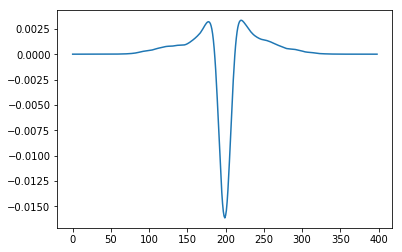

In [405]:
plt.plot(rf_model(0.5, 0.5))

# Gather collection of 1-D filters, sorted by information

In [435]:
chosen_center_weights = [79, 80, 85]
chosen_horz_weights = [7, 80, 140]
chosen_infos = []
chosen_filters = []
actual_cws = []
actual_hws = []
for cw, hw in zip(chosen_center_weights, chosen_horz_weights):
    chosen_infos.append(info_maps[celltype][hw, cw])
    actual_cws.append(center_weights[cw])
    actual_hws.append(horz_weights[hw])
    chosen_filters.append(rf_model(actual_hws[-1], actual_cws[-1]))

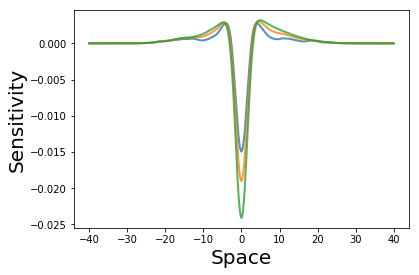

In [443]:
for f in chosen_filters:
    plt.plot(space, f, linewidth=2, alpha=0.8)
    plt.xlabel('Space', fontsize=20)
    plt.ylabel('Sensitivity', fontsize=20)

# Convert filters to 2-D

In [477]:
filters_2d = []
center = int(np.round(len(space)/2.0))
for f in chosen_filters:
    f_2d = np.zeros((len(space), len(space)))
    for x in range(len(space)):
        for y in range(len(space)):
            distance = int(np.round(np.sqrt((x - center)**2 + (y - center)**2)))
            if distance >= center - 1:
                f_2d[x,y] = 0.0
            else:
                f_2d[x,y] = f[distance + center]
    # convert the sum of the new filter to that of the older.
    f_2d *= np.sum(f)/np.sum(f_2d)
    filters_2d.append(f_2d)

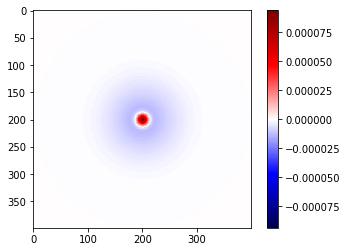

In [478]:
which_one = 2
plt.imshow(filters_2d[which_one], cmap='seismic', clim=[-np.max(abs(filters_2d[which_one])),
                                                        np.max(abs(filters_2d[which_one]))])
plt.colorbar()

In [490]:
np.sum(filters_2d[which_one])

-0.14093959731543607

In [491]:
np.sum(chosen_filters[which_one])

-0.14093959731543609

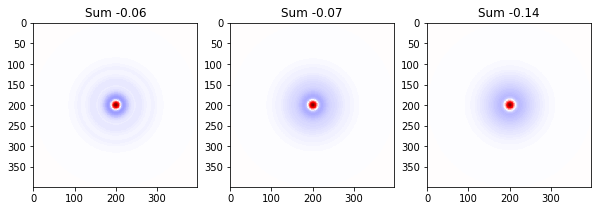

In [499]:
fig = plt.figure(figsize=(10,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow
    which_one = i
    plt.imshow(filters_2d[which_one], cmap='seismic', clim=[-np.max(abs(filters_2d[which_one])),
                                                            np.max(abs(filters_2d[which_one]))])
    plt.title('Sum %0.2f' %np.sum(filters_2d[which_one]))

### Truncate filters to minimize edge effects.

In [500]:
truncated_filters_2d = []
for f_2d in filters_2d:
    truncated_filters_2d.append(f_2d[100:-100, 100:-100])

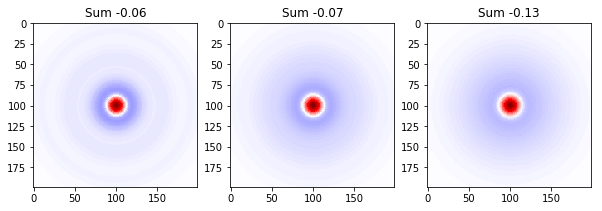

In [502]:
fig = plt.figure(figsize=(10,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow
    which_one = i
    plt.imshow(truncated_filters_2d[which_one], cmap='seismic', clim=[-np.max(abs(truncated_filters_2d[which_one])),
                                                            np.max(abs(truncated_filters_2d[which_one]))])
    plt.title('Sum %0.2f' %np.sum(truncated_filters_2d[which_one]))

In [ ]:
filtered_images = {}
for i, f_2d in tqdm(enumerate(truncated_filters_2d)):
    filtered_images[i] = [convolve2d(p, f_2d, mode='valid') for p in patches]

0it [00:00, ?it/s]

In [ ]:
filtered_images[0][0].shape